In [0]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')



In [0]:
import os
import pandas as pd


current_path = os.getcwd()  
target_path = os.path.abspath(os.path.join(
    current_path,
    "../../../data/customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
))

# import our data from csv file
df = pd.read_csv(target_path)

# show two rows
df.head(2)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Let's first clarify the variables of our dataset:

customerID – Unique identifier for each customer.

gender – Customer’s gender (e.g., Male/Female).

SeniorCitizen – Indicates if the customer is a senior (1 = Yes, 0 = No).

Partner – Whether the customer has a spouse/partner.

Dependents – Whether the customer has dependents (children, etc.).

tenure – Number of months the customer has stayed with the company.

PhoneService – Whether the customer has phone service.

MultipleLines – Whether the customer has multiple phone lines.

InternetService – Type of internet service (DSL, Fiber, None).

OnlineSecurity – Whether the customer has online security add-on.

OnlineBackup – Whether the customer has online backup add-on.

DeviceProtection – Whether the customer has device protection add-on.

TechSupport – Whether the customer has tech support add-on.

StreamingTV – Whether the customer has streaming TV service.

StreamingMovies – Whether the customer has streaming movie service.

Contract – Customer’s contract type (Month-to-month, 1-year, 2-year).

PaperlessBilling – Whether the customer uses paperless billing.

PaymentMethod – Customer’s payment method (e.g., credit card, bank transfer).

MonthlyCharges – Amount charged to the customer each month.

TotalCharges – Total amount charged over the entire tenure.

Churn – Indicates if the customer left the service (Yes/No).


In [0]:
# explore the data
df.shape

(7043, 21)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [0]:
# missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Some necessary operations on variables:
1. Columns to Drop
These features are removed because they do not provide useful predictive information. They typically act as identifiers and only add noise to the dataset.

2. Target Variable
This represents the outcome the model is designed to predict. It serves as the reference point that guides how the algorithm learns patterns from the input features.

3. Boolean Columns
These features already exist in a binary numeric form, such as 0/1. Because of this, they require little to no preprocessing before being used in the model.

4. Columns to Convert to Boolean
These contain yes/no values stored as text and must be converted into binary form. Converting them ensures the model can interpret them correctly and uniformly.

5. Numerical Columns
These features contain measurable numeric values that often hold strong predictive importance. They may require scaling to keep their ranges consistent across the dataset.

6. Categorical Columns
These features contain text-based categories representing qualitative characteristics. They need to be encoded into numerical values so machine-learning algorithms can process them.

In [0]:
# 1 drop useless columns
df = df.drop(columns="customerID",axis=1)
df.shape

(7043, 20)

In [0]:
# there is other type of missing values
count = (df['tenure'] == 0).sum()
print(count)


11


In [0]:
df = df.drop(df[df['tenure'] == 0].index)
print((df['tenure'] == 0).sum())

0


In [0]:
# Let's correct the column of total charges
# convert to numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df["TotalCharges"].mean())
df['TotalCharges'].isna().sum()


np.int64(0)

In [0]:
# check duplicated values
(df.duplicated()).sum()

np.int64(22)

In [0]:
# drop duplicated values
df.drop_duplicates(inplace=True)
(df.duplicated()).sum()

np.int64(0)

Data Visualization

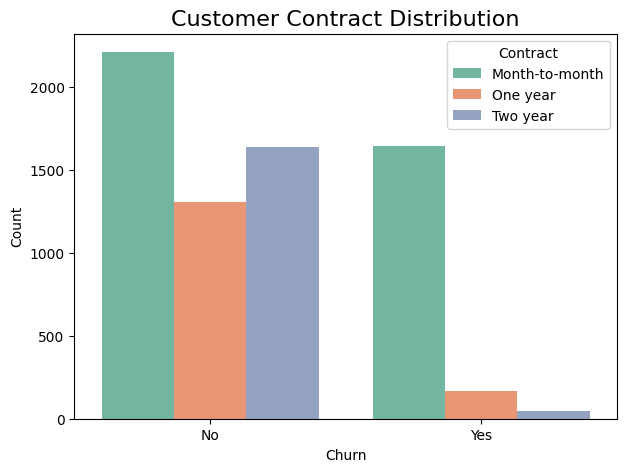

In [0]:
# Let's understand the churn distribution according to the distribution of the contract type

# Set the figure size
plt.figure(figsize=(7, 5))

# Draw a count plot (like a histogram) with bars colored by 'Contract' type
sns.countplot(
    data=df,
    x="Churn",      # X-axis: churn status
    hue="Contract", # Color bars by contract type
    palette="Set2"  # Color palette
)

# Add title and axis labels
plt.title("Customer Contract Distribution", fontsize=16)
plt.xlabel("Churn")
plt.ylabel("Count")
plt.legend(title="Contract")  # Legend title

# Display the plot
plt.show()


In [0]:
# =======================================
# 1️⃣ Project Setup & Data Collection
# =======================================

# =======================================
# 2️⃣ Exploratory Data Analysis (EDA)
# =======================================

# =======================================
# 3️⃣ Data Cleaning & Preprocessing
# =======================================

# =======================================
# 4️⃣ Feature Engineering
# =======================================

# =======================================
# 5️⃣ Model Building & Training
# =======================================

# =======================================
# 6️⃣ Model Evaluation & Business Analysis
# =======================================

# =======================================
# 7️⃣ Model Explainability
# =======================================

# =======================================
# 8️⃣ Model Deployment (API)
# =======================================

# =======================================
# 9️⃣ User Interface / Dashboard (Optional)
# =======================================

# =======================================
# 🔟 Portfolio & Documentation
# =======================================
